# Setup & EDA


### Objectives

This notebook evaluates various machine learning approaches to credit card fraud detection. The dataset is from the [Credit Card Fraud Detection at Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud), which contains transactions made by credit cards in September 2013 by European cardholders: 492 frauds out of 284,807 transactions.

The business objective of a fraud detection system is essentially finding the **optimal sensitivity of the fraud filter to maximize its economic benefits**. 

In [ ]:
import pandas as pd
import numpy as np

import scipy
import math
import time

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore')

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import make_scorer, confusion_matrix, classification_report,\
                            roc_curve, roc_auc_score, average_precision_score
from sklearn import svm
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.initializers import Constant

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#setting seed
SEED=2020
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
#getting data shape
path = '/content/drive/My Drive/Personal/Work/Online/Jupyter/Git/Credit_card_fraud'
df = pd.read_csv(path+'/creditcard.csv')
print(df.shape)

(284807, 31)


In [ ]:
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
211253,138331.0,-0.424849,1.440450,1.144727,2.770542,1.274736,-0.266094,1.160302,-0.151599,-1.942956,0.649006,-1.297299,0.073363,1.165797,-0.124062,-1.486308,0.614403,-0.906942,-0.371149,-1.706106,-0.112490,0.270038,0.812179,-0.253067,0.072351,-0.149161,0.011216,0.139467,0.183261,1.71,0
216519,140515.0,1.923825,-0.285707,-1.730333,-0.046817,1.372527,1.705817,-0.140174,0.363828,0.511349,-0.160968,-0.455742,0.855811,0.678516,0.185762,0.898574,-1.310042,0.685846,-2.631184,-1.056752,-0.257473,-0.173432,-0.196649,0.340552,-1.285473,-0.372171,0.412211,-0.005250,-0.075931,10.60,0
280714,169705.0,1.928541,-0.338794,-0.773928,1.023823,0.027824,0.601129,-0.608708,0.282794,0.857511,0.376208,-0.058585,0.136016,-1.096098,0.377965,-0.058470,0.642468,-1.017357,0.948728,-0.121239,-0.242521,0.156631,0.482619,0.086723,-0.016709,-0.023490,-0.589910,0.033751,-0.042676,25.00,0
92856,64140.0,0.990399,-0.162846,1.256590,1.277200,-0.825194,0.305162,-0.672139,0.328584,0.567870,-0.077904,0.152274,0.013643,-0.775626,0.221115,1.986134,0.033850,0.024550,-0.570541,-1.557875,-0.169263,0.194705,0.538353,0.071150,0.061135,0.104104,-0.323222,0.082969,0.041972,45.00,0
168088,119061.0,1.777328,-0.153731,0.443905,3.522905,-0.299301,1.604670,-1.216280,0.615849,-0.005621,1.534559,-0.450045,-0.424607,-0.937974,-0.096456,-0.489811,2.154432,-1.605501,1.294811,-1.447697,-0.212798,0.233492,0.552009,0.197448,0.020809,-0.479260,-0.041677,0.024602,-0.023316,37.83,0


In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# Number of transactions in each class, fraud ratio
print(df.Class.value_counts())
print(f'{df.Class.mean():.6f}  {1/df.Class.mean():.1f}')

0    284315
1       492
Name: Class, dtype: int64
0.001727  578.9


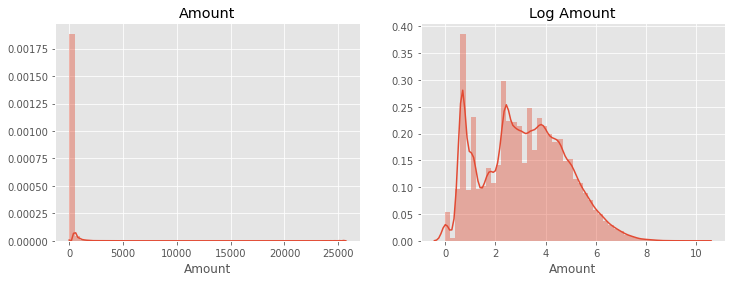

In [ ]:
# Log transformation of Amount
# we do log transoformation because it can be used to make highly kewed distributions less skewed. sThis can be valuable both for making patterns
# in the data more interpretable and for helping to meet the assumptions of inferential statistics. 

_, (ax0,ax1) = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(df.Amount, ax=ax0)
ax0.set_title('Amount')
sns.distplot(np.log1p(df.Amount), ax=ax1)
ax1.set_title('Log Amount')
plt.show()

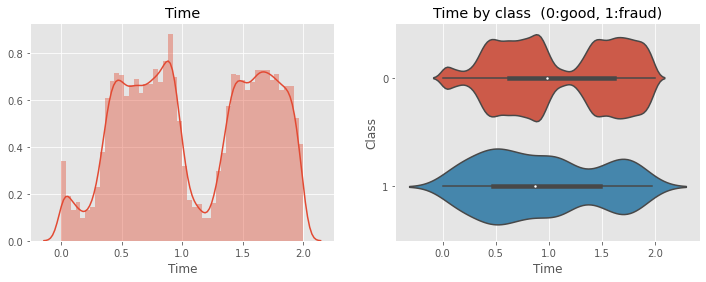

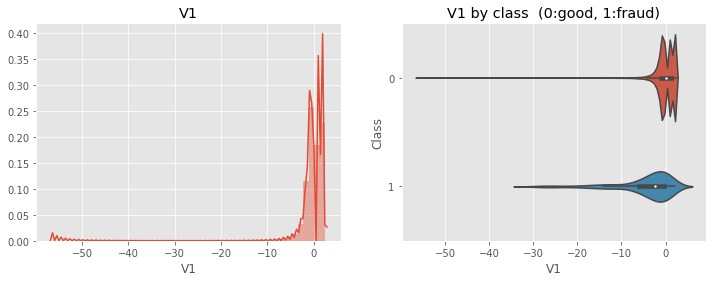

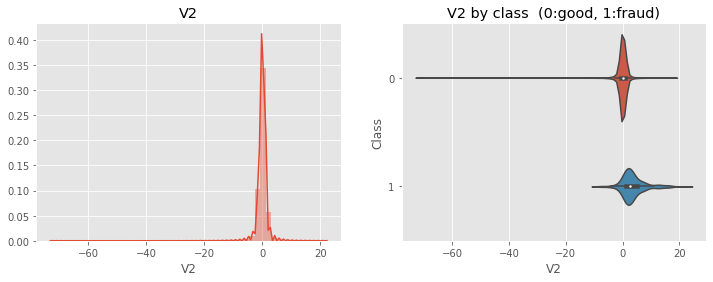

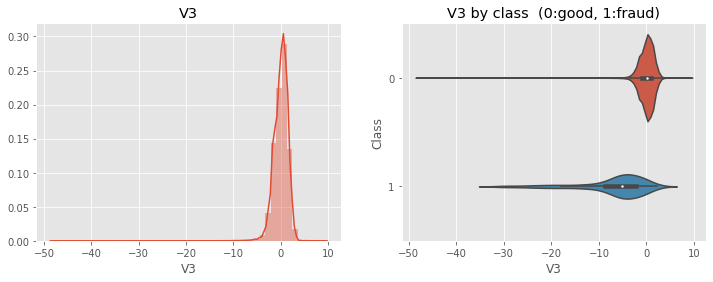

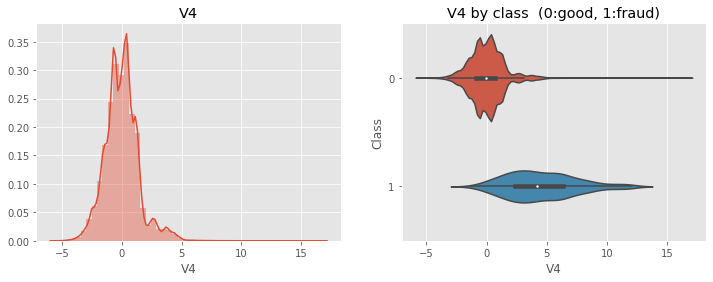

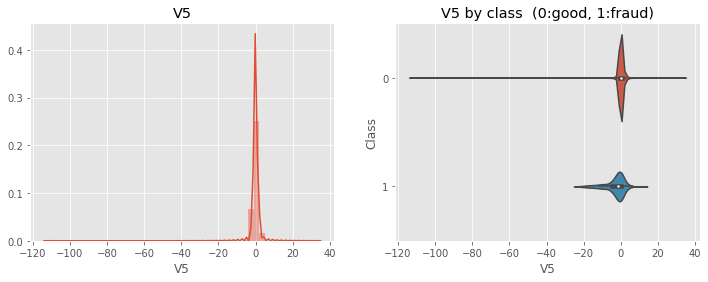

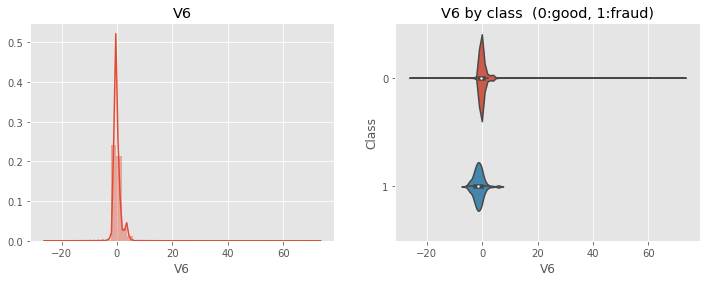

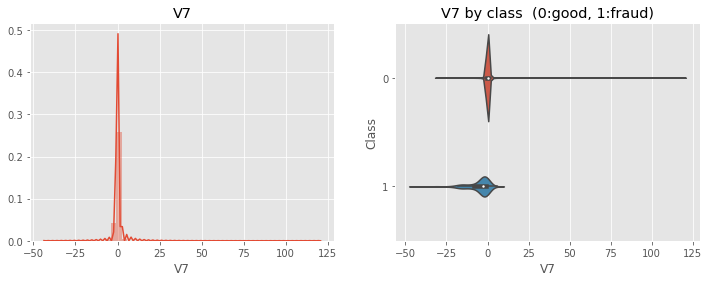

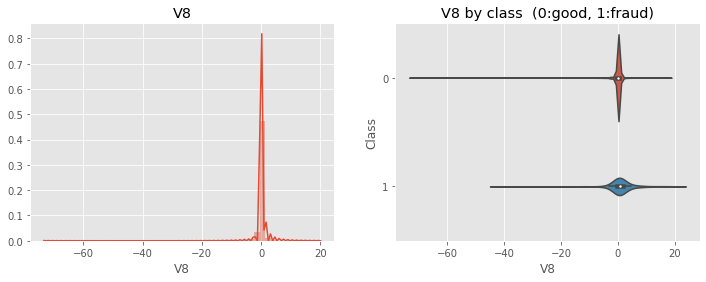

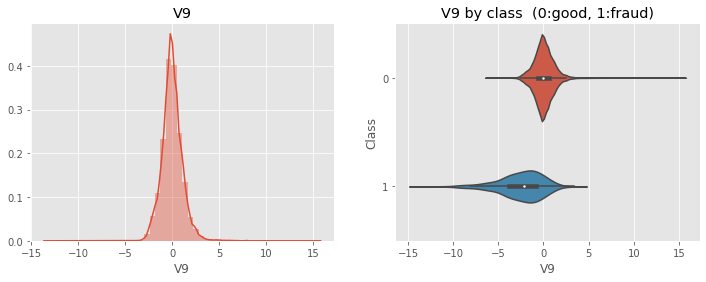

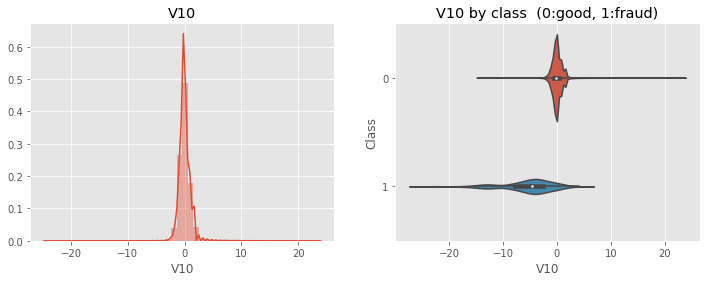

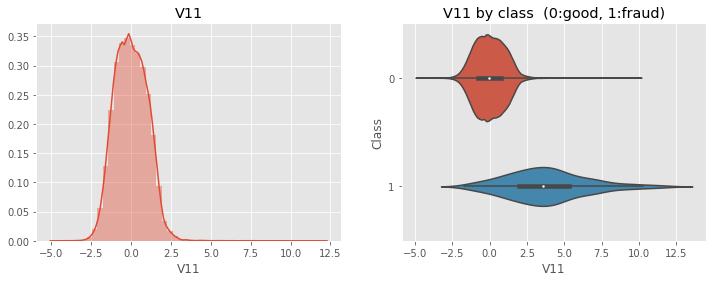

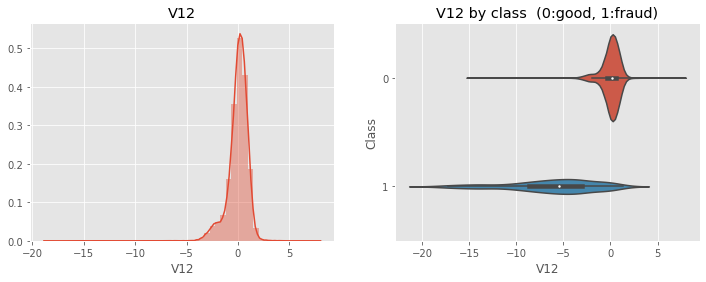

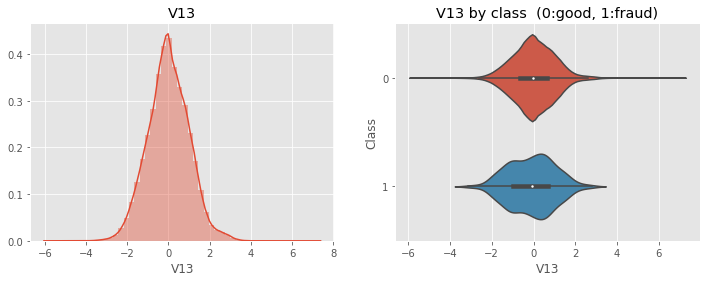

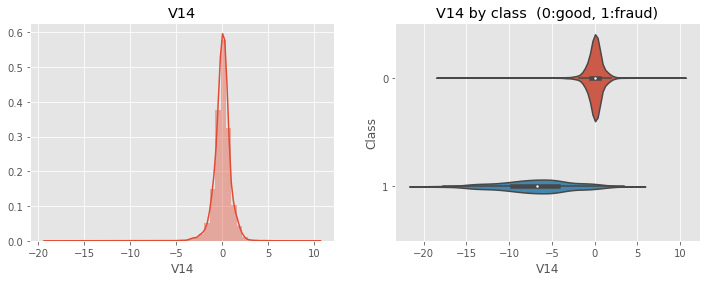

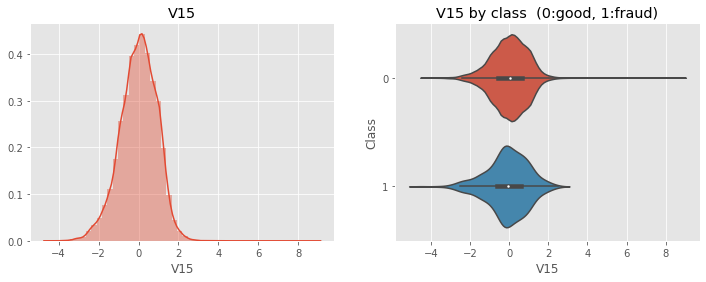

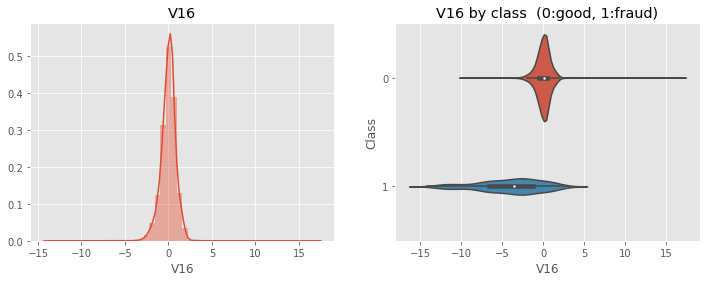

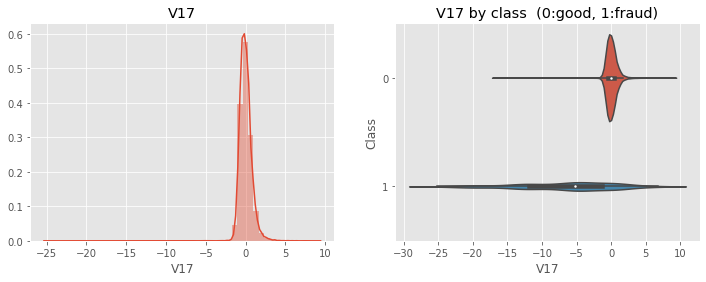

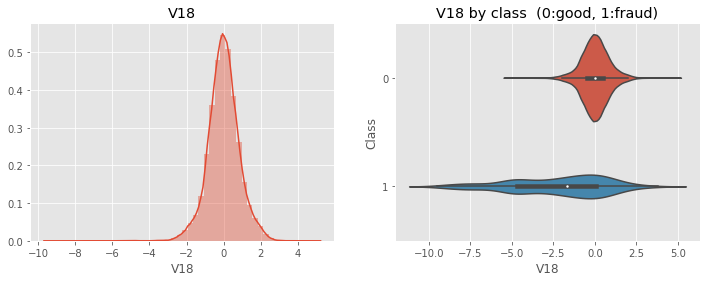

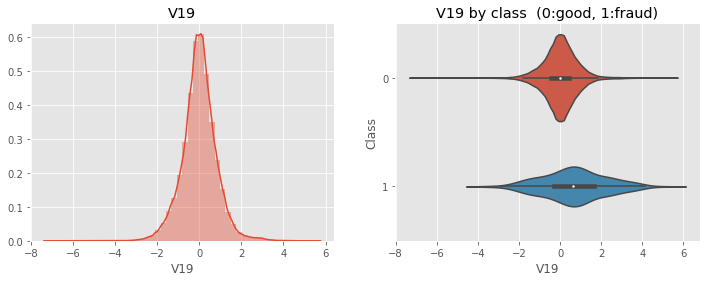

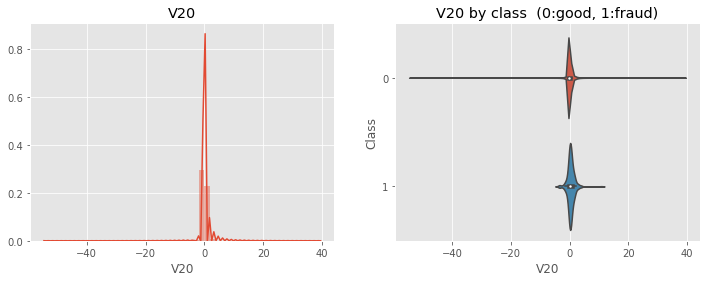

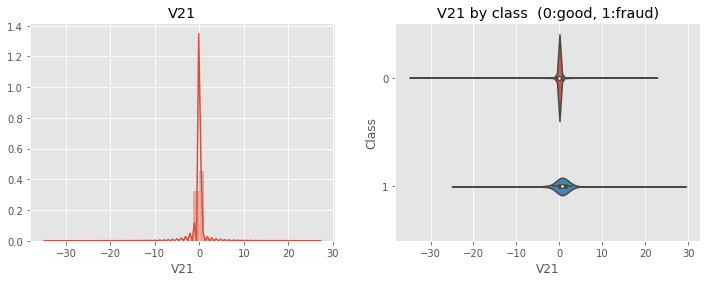

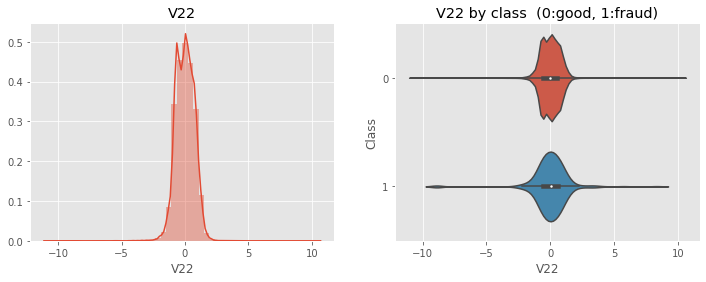

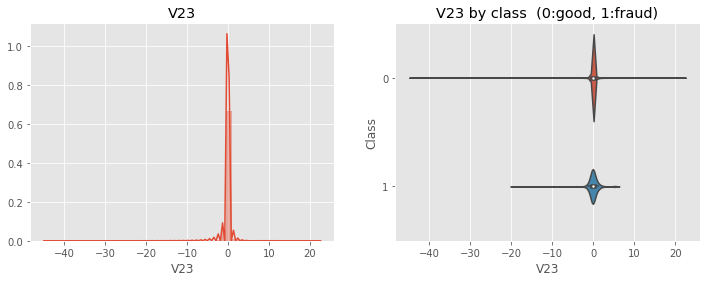

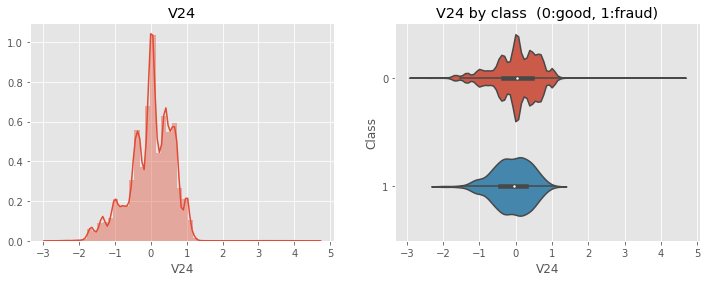

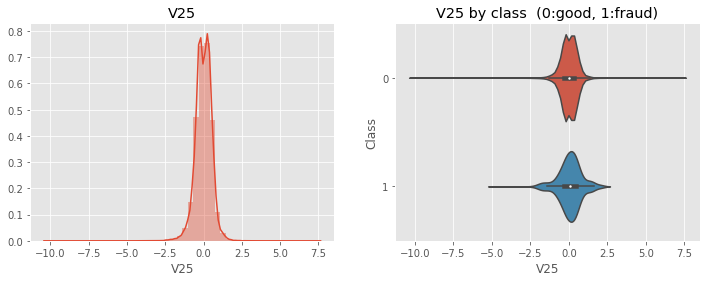

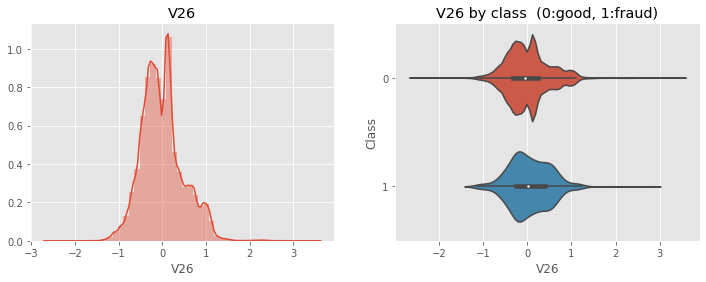

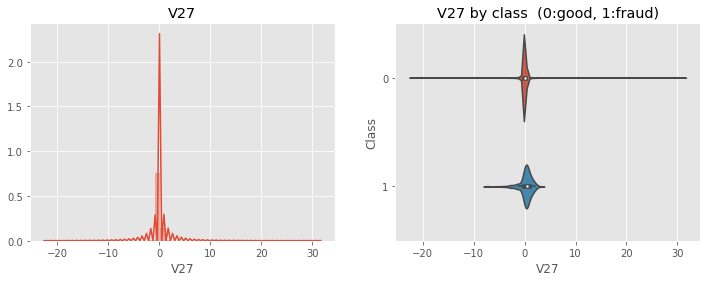

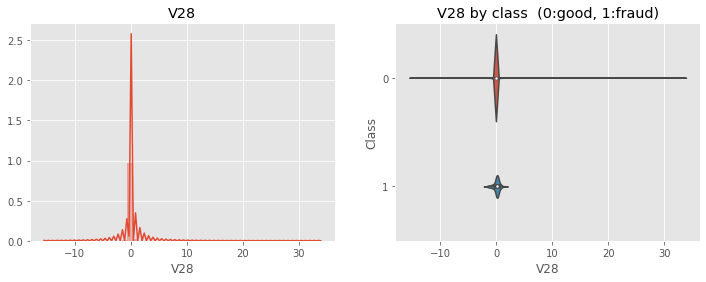

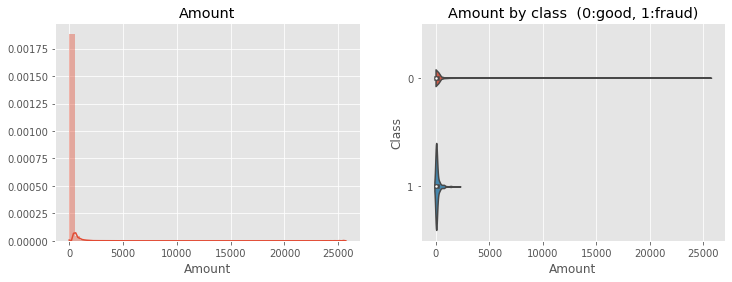

In [ ]:
# Log transform the price and creates a new variable
df['logamount'] = np.log1p(df.Amount)
# lets vizualize the features over the time frame 
# Scale time from seconds to days: time->time/86400
df.Time = df.Time/86400

def plot_feature(f):
    _, (ax0,ax1) = plt.subplots(1, 2, figsize=(12, 4))
    sns.distplot(df[f], ax=ax0)
    ax0.set_title(f)
    sns.violinplot(f,'Class',data=df, orient='h', ax=ax1)
    ax1.set_title(f'{f} by class  (0:good, 1:fraud)')
    plt.show()

for f in df.columns[:-2]:
    plot_feature(f)

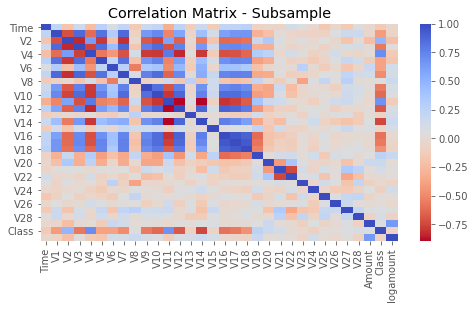

In [ ]:
# downsample good transactions to equal the fraud count to make correlation coeffs. more salient
sub_df = pd.concat([df[df.Class==1], df[df.Class==0].sample(sum(df.Class), random_state=SEED)], axis=0)
plt.figure(figsize=(8,4))
sns.heatmap(sub_df.corr(), cmap='coolwarm_r')
plt.title('Correlation Matrix - Subsample')
plt.show()

In [ ]:
# i'm not doing validation split  because i think i barely have enough fraud data points for training so i don't want to reduce them further 
TEST_SIZE = 0.2

X_train, X_test = train_test_split(df, test_size=TEST_SIZE, random_state=SEED)

print('train shape: ', X_train.shape)
print(X_train.Class.value_counts())
print(f'{X_train.Class.mean():.6f}  {1/X_train.Class.mean():.1f}')
print(50*'-')
print('test shape: ', X_test.shape)
print(X_test.Class.value_counts())
print(f'{X_test.Class.mean():.6f}  {1/X_test.Class.mean():.1f}')

train shape:  (227845, 32)
0    227446
1       399
Name: Class, dtype: int64
0.001751  571.0
--------------------------------------------------
test shape:  (56962, 32)
0    56869
1       93
Name: Class, dtype: int64
0.001633  612.5


In [ ]:
# removing the amount and classfrom the test data 
# removing amount because i don't think it would be a feature for determining if a transcation is fraud or not
A_test = X_test.pop('Amount') 
Y_test = X_test.pop('Class')

To address the class imbalance, we downsample the majority class, bringing the ratio of fraud:good from 1:600 to 1:1 or 1:10


In [ ]:
# G is the ratio of good:bad transactions to be left in the training set. 

G = 10
X_train = pd.concat([X_train[X_train.Class==1],
                    X_train[X_train.Class==0].sample(G*sum(X_train.Class), random_state=SEED)
                    ], axis=0)

print('Subsampled train shape: ', X_train.shape)
print(X_train.Class.value_counts())
print(f'{X_train.Class.mean():.6f}  {1/X_train.Class.mean():.1f}')


Subsampled train shape:  (4389, 32)
0    3990
1     399
Name: Class, dtype: int64
0.090909  11.0


In [ ]:
# Removing amount and class from training data
# Freeze TRAIN
A_train = X_train.pop('Amount')
Y_train = X_train.pop('Class')

In [ ]:
def plot_tsne(X_emb, Y):
    plt.figure(figsize=(10, 8))
    plt.scatter(X_emb[np.where(Y==0), 0], X_emb[np.where(Y==0), 1], marker='.', color='g', alpha=1, label='Non Fraud')
    plt.scatter(X_emb[np.where(Y==1), 0], X_emb[np.where(Y==1), 1], marker='o', color='r', alpha=0.5, label='Fraud')
    plt.title('t-SNE embedding')
    plt.legend(loc='best')
    plt.show()

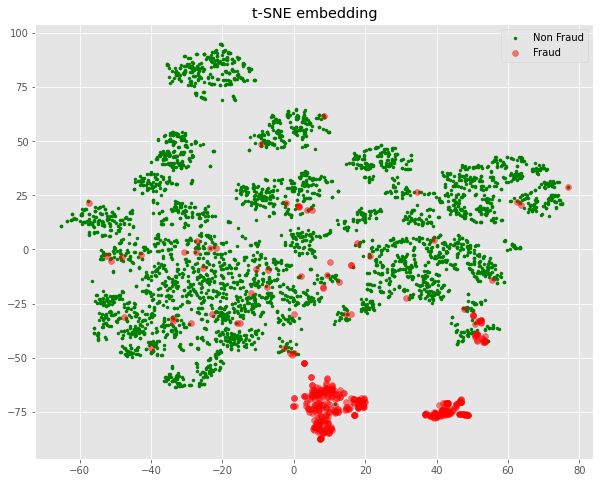

In [ ]:
tsne = TSNE(n_components=2, random_state=SEED)
X_emb = tsne.fit_transform(X_train)
plot_tsne(X_emb, Y_train)


### Helpers

Standard evaluation - all models should call this methods

In [ ]:
# Accumulate best-in-class classifiers to produce final comparison
Y_hats_best = []
classifiers_best = []

In [ ]:
# Initialize report dataframe
def new_report():
    return pd.DataFrame(columns=['classifier', 
                                'TN', 'FP', 'FN', 'TP',
                                'AUC', 'AUPRC', 
                                'max_gain',   # maximum net gain achieved at the optimal cutoff threshold
                                              # calculated as % of total gain of a perfect filter
                                'precision', 'recall', 'fpr',  # all for the optimal cutoff threshold
                                ])
reports = new_report()
reports

,classifier,TN,FP,FN,TP,AUC,AUPRC,max_gain,precision,recall,fpr


In [ ]:
def threshold_arrays(y_true, y_hat):
    """
    Inputs:
        y, array of int 0/1, ground truth labels for good/fraud
        y_hat, array of float, predicted probabilities of fraud
    Outputs:
        Threshold arrays: thresholds, precision, recall, fpr
    """
    fpr, recall, thresholds = roc_curve(y_true, y_hat)
    thresholds[0]=1  #remedy sklearn's artifact of thresholds[0]>1
    precision = 1/(1+(fpr/recall)*(len(y_true)/sum(y_true)-1)) 
    
    stay = np.full_like(thresholds, True, dtype=bool)
    if len(thresholds)>1_000: # downsize all arrays to size <1_000 (to speed up calculations)
        stay[100:-100] = False         
        stay[100:-100:1+len(thresholds)//1000] = True  # in between, leave only nth element s.t. total len<~1_000

    thresholds, precision, recall, fpr = thresholds[stay], precision[stay], recall[stay], fpr[stay]

    return thresholds, precision, recall, fpr


In [ ]:
def optimal_points(y_true, 
                   y_hat, 
                   amount,
                   MARGIN=0,
                   CHARGEBACK=0,
                   LOST=0,
                   EXT=0,
                   ):    
    """
    Inputs: 
        y, array of int 0/1, ground truth labels for good/fraud
        y_hat, array of float, predicted probabilities of fraud
        amount, array of float, amounts in EUR for respective transactions
    Output: 
        Metrics for the optimal point that maximizes the economic effect of the fraud filter:
        opt_gain, opt_precision, opt_recall, opt_fpr, opt_threshold
    """
    thresholds, precision, recall, fpr = threshold_arrays(y_true, y_hat)

    net_gain = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        tp = (y_hat>t)*y_true     ==1  # array of Bool - True Positives
        fp = (y_hat>t)*(1-y_true) ==1  # array of Bool - False Positives
        net_gain[i] = (1-MARGIN)*sum(amount[tp]) + CHARGEBACK*sum(tp) - MARGIN*LOST*sum(amount[fp]) - EXT*sum(fp)

    # optimal (maximum) economic gain as % of the gain of a perfect filter (TP=P, FP=0)
    opt_gain = max(net_gain) / ((1-MARGIN)*sum(amount[y_true==1]) + CHARGEBACK*sum(y_true))

    # optimal point metrics
    idx = np.argmax(net_gain)
    opt_precision = precision[idx]
    opt_recall    = recall[idx]
    opt_fpr       = fpr[idx]
    opt_threshold = thresholds[idx]
    
    return opt_gain, opt_precision, opt_recall, opt_fpr, opt_threshold

In [ ]:
def report(classifier_name, y_hat, y_true=Y_test, amount=A_test):
    """
    Inputs:
        y, array of int 0/1, ground truth labels for good/fraud
        y_hat, array of float, predicted probabilities of fraud
        amount, array of float, amounts in EUR for respective transactions
    Output: 
        report dataframe of 1 row 
    """
    AUC   = roc_auc_score(y_true, y_hat)
    AUPRC = average_precision_score(y_true, y_hat)
    opt_gain, opt_precision, opt_recall, opt_fpr, opt_threshold = optimal_points(y_true, y_hat, amount)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat>opt_threshold).ravel()

    df = new_report()
    df.loc[0] = ([classifier_name, 
                    tn, fp, fn, tp,
                    f'{AUC:.3f}',
                    f'{AUPRC:.3f}',
                    f'{opt_gain:.3f}',
                    f'{opt_precision:.3f}',
                    f'{opt_recall:.3f}',
                    f'{opt_fpr:.6f}',
                    ])
    return df


In [ ]:
def plot_classifiers(title, classifiers, y_hats, y_true=Y_test, amount=A_test):    

    _,(ax0,ax1) = plt.subplots(1, 2, figsize=(16, 6))

    for i, y_hat in enumerate(y_hats):
    
        thresholds, precision, recall, fpr = threshold_arrays(y_true, y_hat)
        opt_gain, opt_precision, opt_recall, opt_fpr, opt_threshold = optimal_points(y_true, y_hat, amount)
        point_label = 'optimal gain' if i==len(classifiers)-1 else ''

        ax0.plot(recall,  precision, label=f'{classifiers[i]}    AUPRC={average_precision_score(y_true, y_hat):.3f}')
        ax0.set_xlabel('recall')
        ax0.set_ylabel('precision')
        ax0.set_title(f'{title}. Precision-Recall')
        ax0.plot((opt_recall), (opt_precision), color='m', marker='o', label=point_label)
        ax0.legend(loc='lower left')

        ax1.plot(fpr, recall, label=f'{classifiers[i]}    AUC={roc_auc_score(y_true, y_hat):.3f}')
        ax1.set_xlabel('false positive rate')
        ax1.set_ylabel('recall')
        ax1.set_title(f'{title}. ROC for FRP<0.1%')
        ax1.plot((opt_fpr), (opt_recall), color='m', marker='o', label=point_label)
        ax1.legend(loc='lower right')
        ax1.set_xlim(0,0.001)

    plt.show()

### Logistic Regression

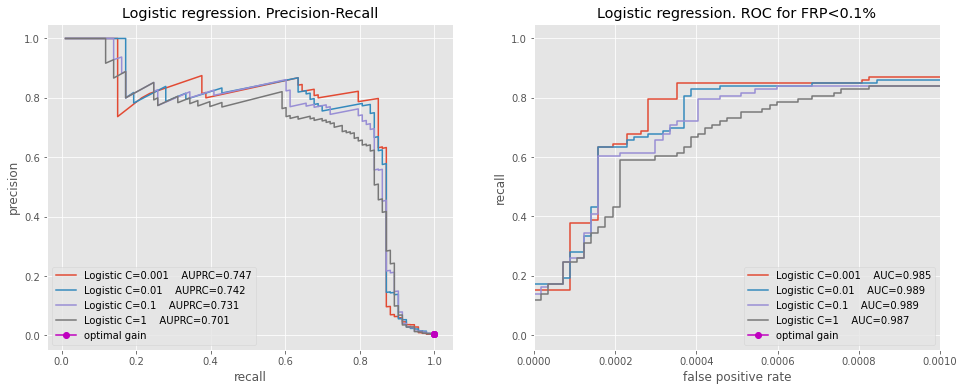

In [ ]:
model = linear_model.LogisticRegression(penalty='l2', random_state=SEED)

params = [0.001, 0.01, 0.1, 1]

classifiers, Y_hats = [],[]
for param in params:

    classifiers.append(f'Logistic C={param}')
    model.set_params(C=param)
    model.fit(X_train, Y_train)

    Y_hat = model.predict_proba(X_test)[:,1]
    Y_hats.append(Y_hat)

    reports = pd.concat([reports, report(classifiers[-1], Y_hat)])

plot_classifiers('Logistic regression', classifiers, Y_hats)

In [ ]:
reports

,classifier,TN,FP,FN,TP,AUC,AUPRC,max_gain,precision,recall,fpr
0,Logistic C=0.001,33130,23739,0,93,0.985,0.747,1.000,0.004,1.000,0.417451
0,Logistic C=0.01,40160,16709,0,93,0.989,0.742,1.000,0.006,1.000,0.293833
0,Logistic C=0.1,38605,18264,0,93,0.989,0.731,1.000,0.005,1.000,0.321177
0,Logistic C=1,37399,19470,0,93,0.987,0.701,1.000,0.005,1.000,0.342383


In [ ]:
# the best classifier is the one producing maximum economic gain
best_id = np.argmax(reports.max_gain[-len(classifiers):])

Y_hats_best.append(Y_hats[best_id])
classifiers_best.append(classifiers[best_id])

Conclusions from the Logistic Primer:
- Train set negatives:positives of G=1:1 is inferior to G=10:1
- Do not eliminate weakly correlated features
- Regularize! 
- AUPRC is better aligned with the business objective than AUC


### SVM

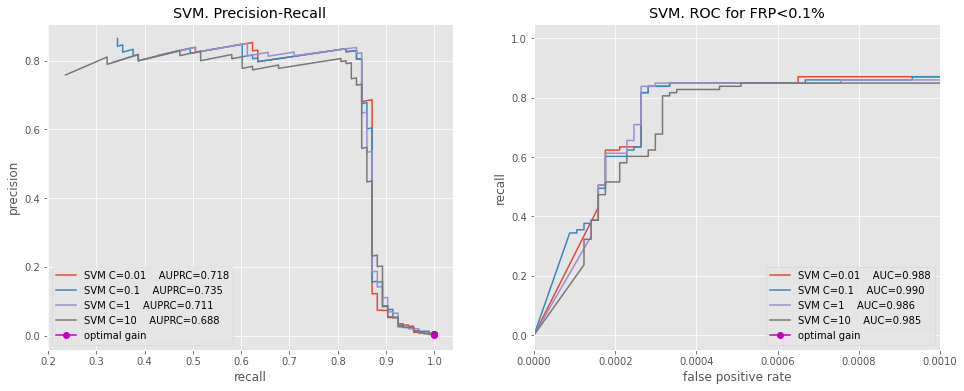

In [ ]:
model = svm.SVC(kernel='poly', C=1, degree=1, probability=True, random_state=SEED)

params = [0.01, 0.1, 1, 10]

classifiers, Y_hats = [],[]
for param in params:

    classifiers.append(f'SVM C={param}')
    model.set_params(C=param)
    model.fit(X_train, Y_train)

    Y_hat = model.predict_proba(X_test)[:,1]
    Y_hats.append(Y_hat)

    reports = pd.concat([reports, report(classifiers[-1], Y_hat)])

plot_classifiers('SVM', classifiers, Y_hats)

In [ ]:
reports

,classifier,TN,FP,FN,TP,AUC,AUPRC,max_gain,precision,recall,fpr
0,Logistic C=0.001,33130,23739,0,93,0.985,0.747,1.000,0.004,1.000,0.417451
0,Logistic C=0.01,40160,16709,0,93,0.989,0.742,1.000,0.006,1.000,0.293833
0,Logistic C=0.1,38605,18264,0,93,0.989,0.731,1.000,0.005,1.000,0.321177
0,Logistic C=1,37399,19470,0,93,0.987,0.701,1.000,0.005,1.000,0.342383
0,SVM C=0.01,39295,17574,0,93,0.988,0.718,1.000,0.005,1.000,0.309044
0,SVM C=0.1,39407,17462,0,93,0.990,0.735,1.000,0.005,1.000,0.307074
0,SVM C=1,29368,27501,0,93,0.986,0.711,1.000,0.003,1.000,0.483603
0,SVM C=10,25220,31649,0,93,0.985,0.688,1.000,0.003,1.000,0.556542


In [ ]:
# the best classifier is the one producing maximum economic gain
best_id = np.argmax(reports.max_gain[-len(classifiers):])

Y_hats_best.append(Y_hats[best_id])
classifiers_best.append(classifiers[best_id])

### XGBoost

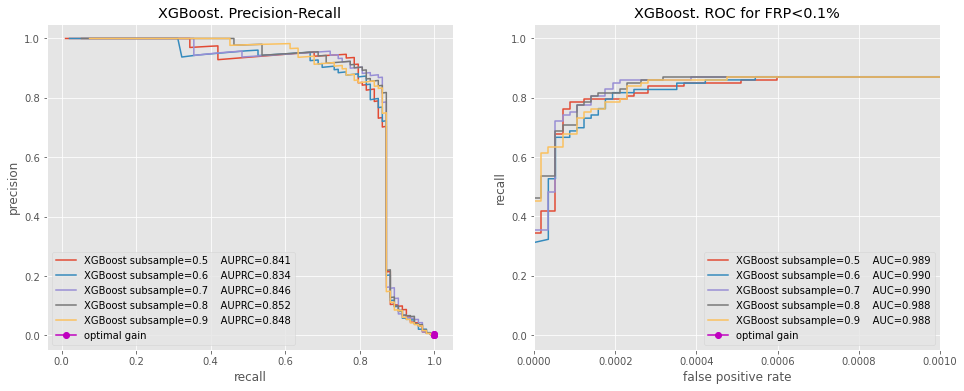

In [ ]:
model= XGBClassifier(   max_depth=3, 
                        learning_rate=0.2,
                        n_estimators=2_000,
                        objective='binary:logistic',
                        subsample=0.75,
                        colsample_bylevel=0.75,
                        colsample_bytree=0.75,
                        gamma=0, 
                        min_child_weight=0, 
                        reg_alpha=0, 
                        reg_lambda=1, 
                        base_score=0.8, 
                        random_state=SEED, 
                     )
params = [0.5, 0.6, 0.7, 0.8, 0.9]

classifiers, Y_hats = [],[]
for param in params:

    classifiers.append(f'XGBoost subsample={param}')
    model.set_params(subsample=param, colsample_bylevel=param, colsample_bytree=param)
    model.fit(X_train, Y_train)

    Y_hat = model.predict_proba(X_test)[:,1]
    Y_hats.append(Y_hat)

    reports = pd.concat([reports, report(classifiers[-1], Y_hat)])

plot_classifiers('XGBoost', classifiers, Y_hats)

In [ ]:
reports

,classifier,TN,FP,FN,TP,AUC,AUPRC,max_gain,precision,recall,fpr
0,Logistic C=0.001,33130,23739,0,93,0.985,0.747,1.000,0.004,1.000,0.417451
0,Logistic C=0.01,40160,16709,0,93,0.989,0.742,1.000,0.006,1.000,0.293833
0,Logistic C=0.1,38605,18264,0,93,0.989,0.731,1.000,0.005,1.000,0.321177
0,Logistic C=1,37399,19470,0,93,0.987,0.701,1.000,0.005,1.000,0.342383
0,SVM C=0.01,39295,17574,0,93,0.988,0.718,1.000,0.005,1.000,0.309044
0,SVM C=0.1,39407,17462,0,93,0.990,0.735,1.000,0.005,1.000,0.307074
0,SVM C=1,29368,27501,0,93,0.986,0.711,1.000,0.003,1.000,0.483603
0,SVM C=10,25220,31649,0,93,0.985,0.688,1.000,0.003,1.000,0.556542
0,XGBoost subsample=0.5,27975,28894,0,93,0.989,0.841,1.000,0.003,1.000,0.508098
0,XGBoost subsample=0.6,32170,24699,0,93,0.990,0.834,1.000,0.004,1.000,0.434332


In [ ]:
# the best classifier is the one producing maximum economic gain
best_id = np.argmax(reports.max_gain[-len(classifiers):])

Y_hats_best.append(Y_hats[best_id])
classifiers_best.append(classifiers[best_id])

XGBoost feature importance

In [ ]:
param = float(classifiers_best[-1].split('=')[1])
model.set_params(subsample=param, colsample_bylevel=param, colsample_bytree=param)
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=0, missing=None, n_estimators=2000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2020,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

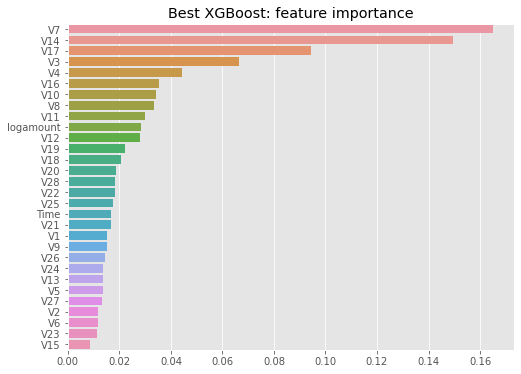

In [ ]:
# Visualize Feature importance
fi = pd.Series(model.feature_importances_, index=X_train.columns) #X_train.columns)
fi = fi.sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot( fi.values, fi.index, orient='h')
plt.title('Best XGBoost: feature importance')
plt.show()

### Neural Network

In [ ]:
EPOCHS     = 50
BATCH_SIZE = 256     # large batch size to include ~1/G positive samples

neg, pos = np.bincount(Y_train)
output_bias = np.log(pos/neg)

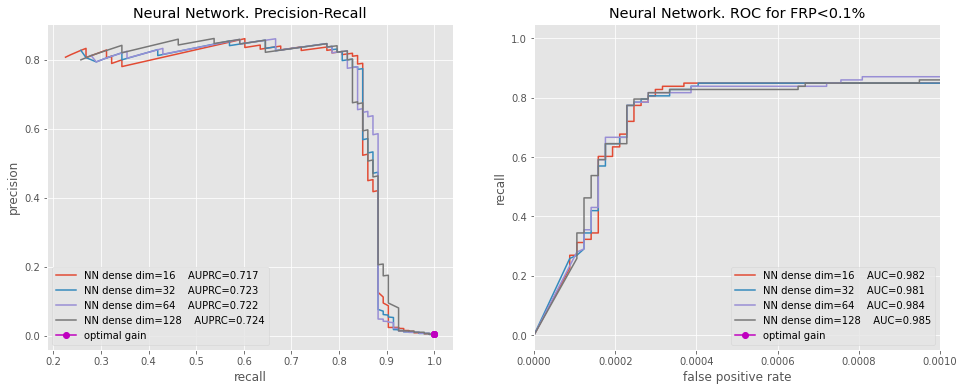

In [ ]:
params = [16, 32, 64, 128]

classifiers, Y_hats = [],[]
for param in params:

    classifiers.append(f'NN dense dim={param}')
    
    input = Input(shape=(X_train.shape[-1],), dtype=tf.int32)
    x = Dense(param, activation='relu')(input)
    x = Dropout(0.2, seed=SEED)(x)
    output = Dense(1, activation='sigmoid', bias_initializer=Constant(output_bias))(x)
    model = Model(input, output)

    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[AUC(name='AUC'), AUC(curve='PR', name='AUPRC')])
    model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)

    Y_hat = np.squeeze(model(X_test.values).numpy()) 
    Y_hats.append(Y_hat)

    reports = pd.concat([reports, report(classifiers[-1], Y_hat)])

plot_classifiers('Neural Network', classifiers, Y_hats)

In [ ]:
reports

,classifier,TN,FP,FN,TP,AUC,AUPRC,max_gain,precision,recall,fpr
0,Logistic C=0.001,33130,23739,0,93,0.985,0.747,1.000,0.004,1.000,0.417451
0,Logistic C=0.01,40160,16709,0,93,0.989,0.742,1.000,0.006,1.000,0.293833
0,Logistic C=0.1,38605,18264,0,93,0.989,0.731,1.000,0.005,1.000,0.321177
0,Logistic C=1,37399,19470,0,93,0.987,0.701,1.000,0.005,1.000,0.342383
0,SVM C=0.01,39295,17574,0,93,0.988,0.718,1.000,0.005,1.000,0.309044
0,SVM C=0.1,39407,17462,0,93,0.990,0.735,1.000,0.005,1.000,0.307074
0,SVM C=1,29368,27501,0,93,0.986,0.711,1.000,0.003,1.000,0.483603
0,SVM C=10,25220,31649,0,93,0.985,0.688,1.000,0.003,1.000,0.556542
0,XGBoost subsample=0.5,27975,28894,0,93,0.989,0.841,1.000,0.003,1.000,0.508098
0,XGBoost subsample=0.6,32170,24699,0,93,0.990,0.834,1.000,0.004,1.000,0.434332


In [ ]:
# the best classifier is the one producing maximum economic gain
best_id = np.argmax(reports.max_gain[-len(classifiers):])

Y_hats_best.append(Y_hats[best_id])
classifiers_best.append(classifiers[best_id])

### Autoencoders

Extract features through an autoencoder network, apply best classifier to extracted features.

In [ ]:
dim = 32

input = Input(shape=(X_train.shape[-1],), dtype=tf.int32)
x = Dense(dim, activation='tanh')(input)
x = Dense(4, activation='tanh')(x)  # the low-dimensional representation
output = Dense(dim, activation='tanh')(x)
autoencoder = Model(input, output)
autoencoder.compile(optimizer=Adam(), loss='mse')
autoencoder.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=100, verbose=0)

# extract features at the low-dimensional encoder layer
extractor = Model(inputs=autoencoder.input, outputs=autoencoder.layers[2].output)

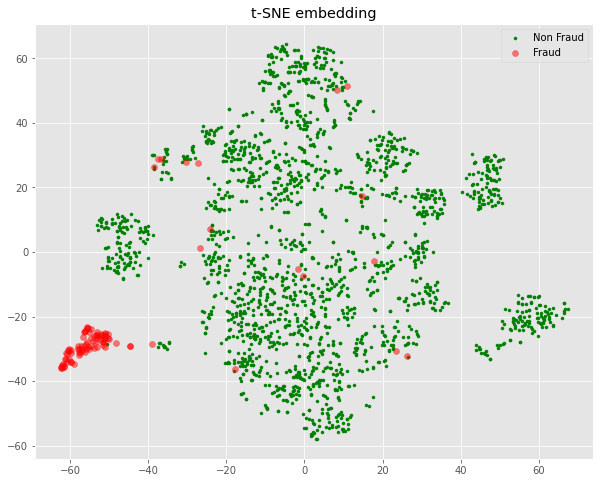

In [ ]:
# Before autoencode
X_test_sub = X_test.copy()
X_test_sub['Class'] = Y_test
X_test_sub = pd.concat([X_test_sub[X_test_sub.Class==1], X_test_sub[X_test_sub.Class==0].sample(2_000, random_state=SEED)])
Y_test_sub = X_test_sub.pop('Class')

plot_tsne(tsne.fit_transform(X_test_sub), Y_test_sub)

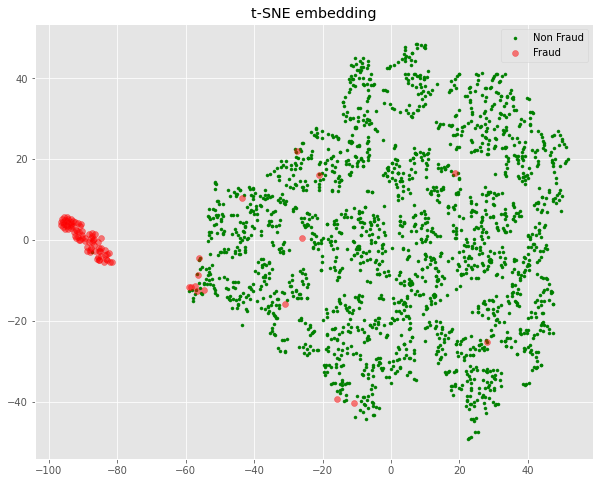

In [ ]:
# After autoencode
X_encoded = np.squeeze(extractor(X_test_sub.values).numpy()) 

plot_tsne(tsne.fit_transform(X_encoded), Y_test_sub)

The two classes become more separable visually in a t-SNE embedding BUT the same amount of False Negatives (~15 red dots) still remain part of the green cloud. Performance of XGBoost did NOT improve when trained on the autoencoded features:

In [ ]:
X_train_e = extractor(X_train.values)
X_train_e.shape

TensorShape([4389, 4])

In [ ]:
X_test_e = np.squeeze(extractor(X_test.values).numpy()) 
X_test_e.shape

(56962, 4)

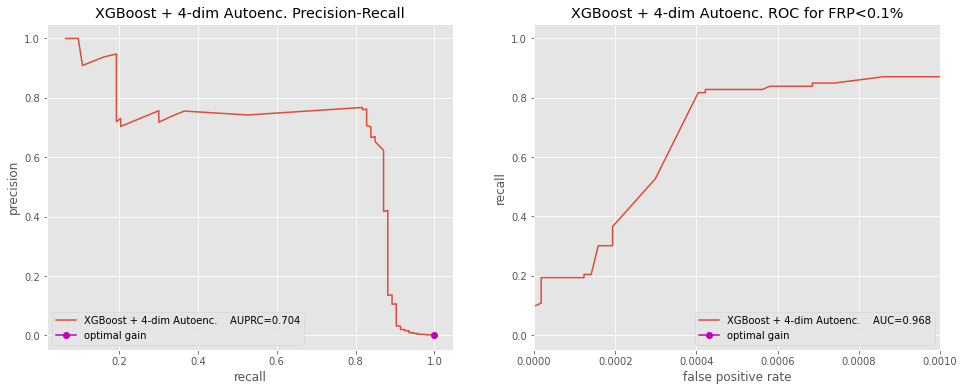

In [ ]:
model= XGBClassifier(   max_depth=3, 
                        learning_rate=0.2,
                        n_estimators=2_000,
                        objective='binary:logistic',
                        subsample=0.75,
                        colsample_bylevel=0.75,
                        colsample_bytree=0.75,
                        gamma=0, 
                        min_child_weight=0, 
                        reg_alpha=0, 
                        reg_lambda=1, 
                        base_score=0.8, 
                        random_state=SEED, 
                     )

model.fit(X_train_e, Y_train)
Y_hat = model.predict_proba(X_test_e)[:,1]
reports = pd.concat([reports, report(f'XGBoost + 4-dim Autoenc', Y_hat)])

classifiers = ['XGBoost + 4-dim Autoenc.']
plot_classifiers('XGBoost + 4-dim Autoenc', classifiers, [Y_hat])

In [ ]:
reports.index = range(len(reports))
reports

,classifier,TN,FP,FN,TP,AUC,AUPRC,max_gain,precision,recall,fpr
0,Logistic C=0.001,33130,23739,0,93,0.985,0.747,1.000,0.004,1.000,0.417451
1,Logistic C=0.01,40160,16709,0,93,0.989,0.742,1.000,0.006,1.000,0.293833
2,Logistic C=0.1,38605,18264,0,93,0.989,0.731,1.000,0.005,1.000,0.321177
3,Logistic C=1,37399,19470,0,93,0.987,0.701,1.000,0.005,1.000,0.342383
4,SVM C=0.01,39295,17574,0,93,0.988,0.718,1.000,0.005,1.000,0.309044
5,SVM C=0.1,39407,17462,0,93,0.990,0.735,1.000,0.005,1.000,0.307074
6,SVM C=1,29368,27501,0,93,0.986,0.711,1.000,0.003,1.000,0.483603
7,SVM C=10,25220,31649,0,93,0.985,0.688,1.000,0.003,1.000,0.556542
8,XGBoost subsample=0.5,27975,28894,0,93,0.989,0.841,1.000,0.003,1.000,0.508098
9,XGBoost subsample=0.6,32170,24699,0,93,0.990,0.834,1.000,0.004,1.000,0.434332


### Compare models

XGBoost shows the best performace **both in Recall and FPR.**

In [ ]:
best_reports = reports[reports.classifier.isin(classifiers_best)]
best_reports

,classifier,TN,FP,FN,TP,AUC,AUPRC,max_gain,precision,recall,fpr
0,Logistic C=0.001,33130,23739,0,93,0.985,0.747,1.000,0.004,1.000,0.417451
4,SVM C=0.01,39295,17574,0,93,0.988,0.718,1.000,0.005,1.000,0.309044
8,XGBoost subsample=0.5,27975,28894,0,93,0.989,0.841,1.000,0.003,1.000,0.508098
13,NN dense dim=16,30255,26614,0,93,0.982,0.717,1.000,0.003,1.000,0.468023


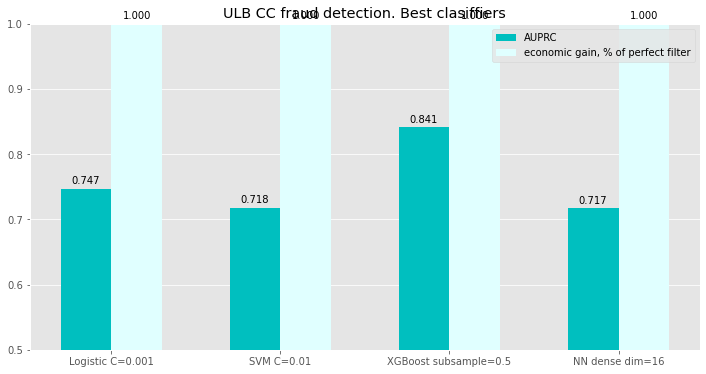

In [ ]:
x = np.arange(len(best_reports))
width = 0.3

fig, ax = plt.subplots(figsize=(12, 6))
AUPRC = ax.bar(x-width/2, best_reports['AUPRC'].astype(float), width, label='AUPRC', color='c')
max_gain = ax.bar(x+width/2, best_reports['max_gain'].astype(float), width, 
                  label='economic gain, % of perfect filter', color='lightcyan')

ax.set_title('ULB CC fraud detection. Best clasiffiers')
ax.set_ylim(0.5,1)
ax.set_xticks(x)
ax.set_xticklabels(best_reports['classifier'])#, rotation=60)
ax.legend(loc='upper right')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', xy=(rect.get_x()+.5*rect.get_width(), height), xytext=(0,3), 
                                     textcoords="offset points", ha='center', va='bottom')
autolabel(AUPRC)
autolabel(max_gain)
# fig.tight_layout()
plt.show()

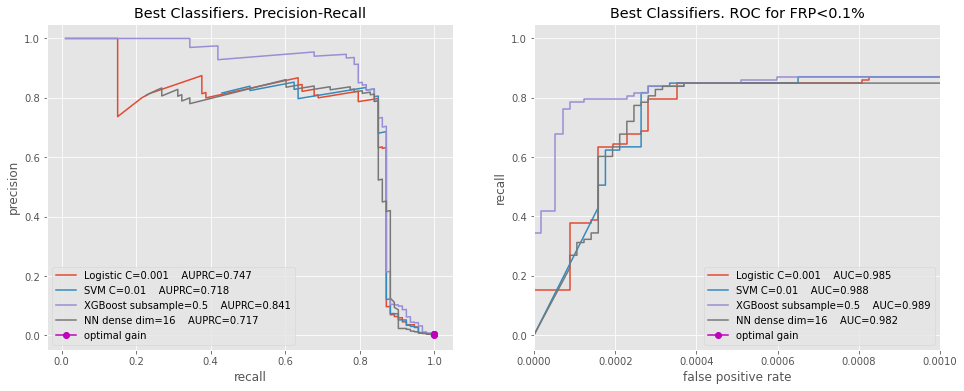

In [ ]:
plot_classifiers('Best Classifiers', classifiers_best, Y_hats_best)